# Import necessary packages

In [1]:
import pandas
import numpy
import retl
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import re
import helper
import scipy.stats
#import seaborn as sns
import matplotlib.gridspec as gridspec

# Data split GFP assay

In [2]:
dir_experiment='9WMNFC'
experiment_name = 'Correlation'

data = []
time = []
n = 22

t0_data = retl.parse(fr'{dir_experiment}\read_01\Output.xml') 
t0 = t0_data['Label1_Copy1_Copy1'].end_utc

for i in range(0,n):
    rdata = retl.parse(fr'{dir_experiment}\read_{i+1:02d}\Output.xml')
    df = rdata['Label1_Copy1_Copy1'].value
    time_end = rdata['Label1_Copy1_Copy1'].end_utc
    runtime = (time_end-t0).seconds/3600
    data.append(df)
    time.append(runtime)
merged_outputs = pandas.concat(data, ignore_index = True)


mypath = fr'{dir_experiment}\{experiment_name}_Results' 
if not os.path.isdir(mypath):
    os.makedirs(mypath)

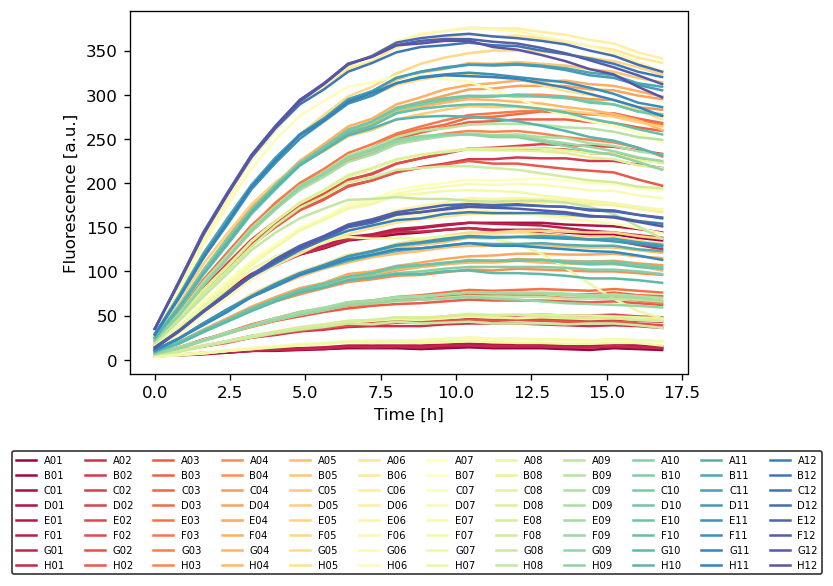

In [3]:
wells = []
for z in range(1, 13):
    z = f'{z:02}'
    well_rows = [f'{r}{z}' for r in 'ABCDEFGH']
    for w in well_rows:
        well = w
        wells.append(str(well))

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=120, sharex=True)

for w, well in enumerate(wells):
    color = plt.cm.Spectral(w/len(wells))
    ax.plot(time, merged_outputs[well], color = color, label = well)
    
#ax.set_xlim(0,18)
#ax.set_ylim(0,400)

ax.set_xlabel('Time [h]')
ax.set_ylabel('Fluorescence [a.u.]')

plt.legend(ncol = 12, edgecolor = 'black',  prop={'size':6}, bbox_to_anchor = (1.25,-0.2))
plt.savefig(fr'{dir_experiment}/{experiment_name}_Results/{experiment_name}_sGFP_all', dpi= 1200)

C:\Users\muellerc\AppData\Local\Continuum\miniconda3\envs\dibecs_3.2.2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


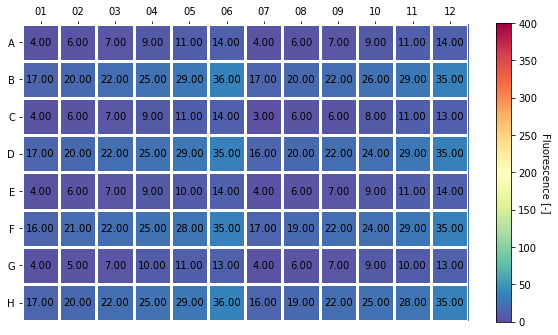

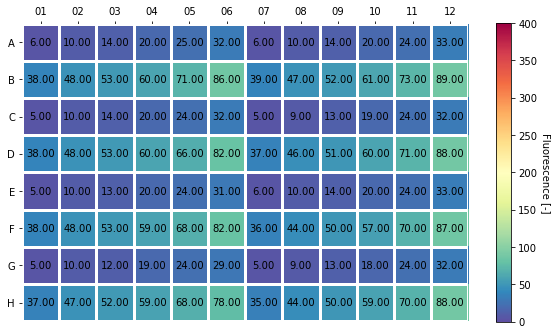

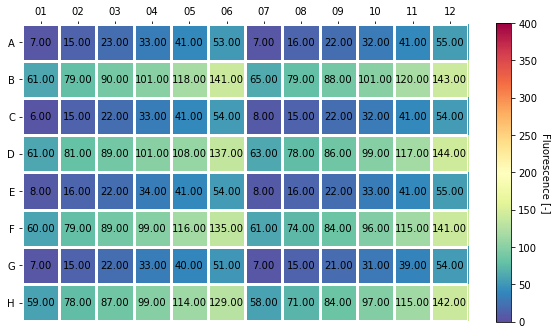

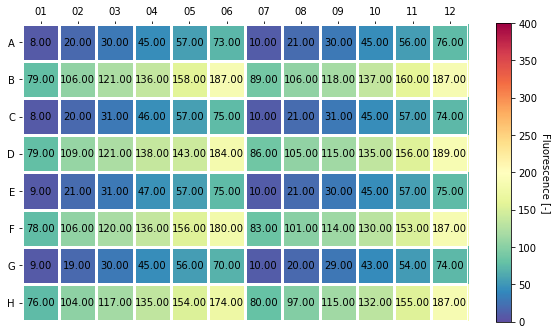

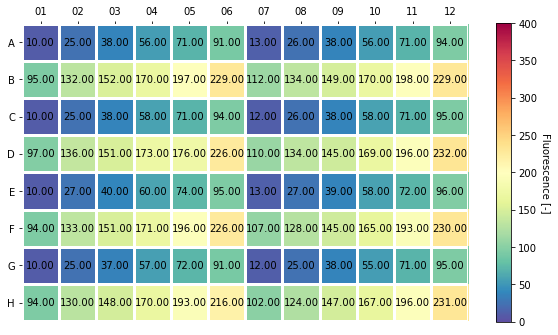

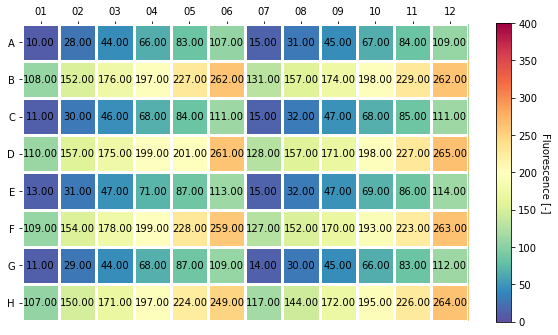

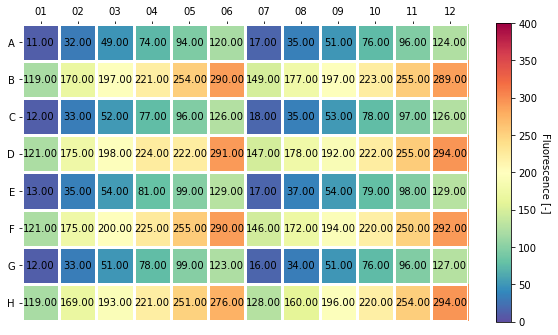

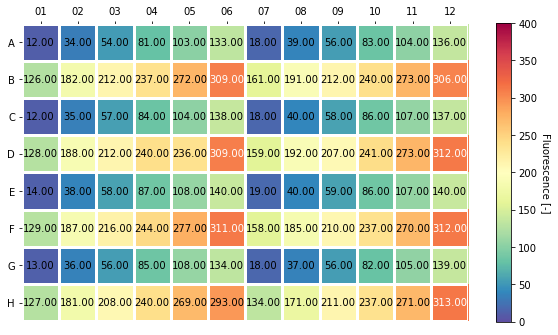

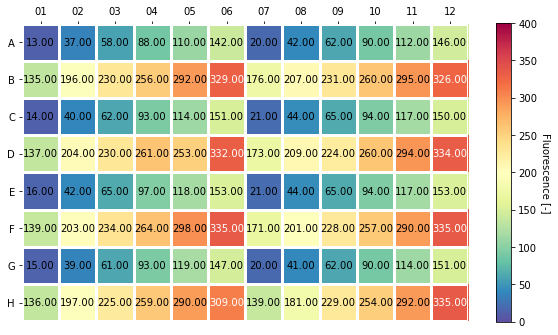

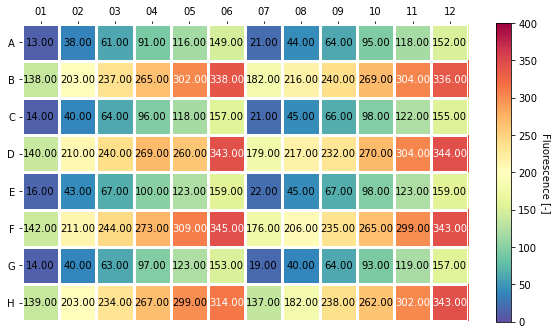

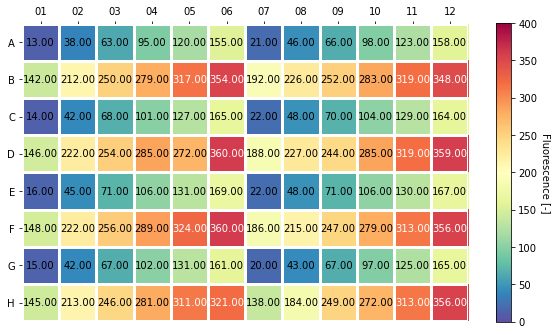

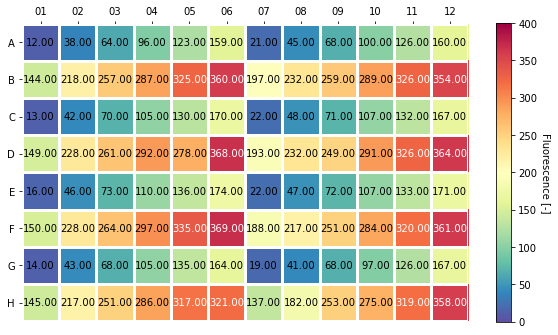

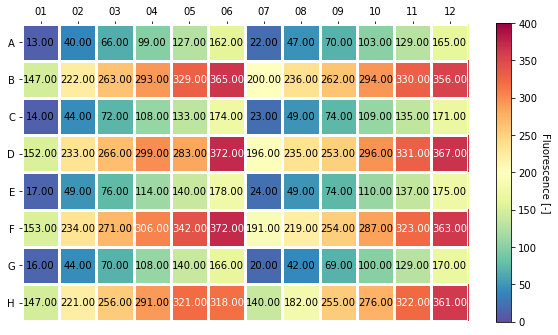

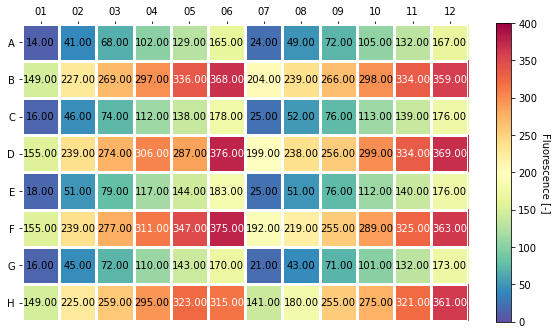

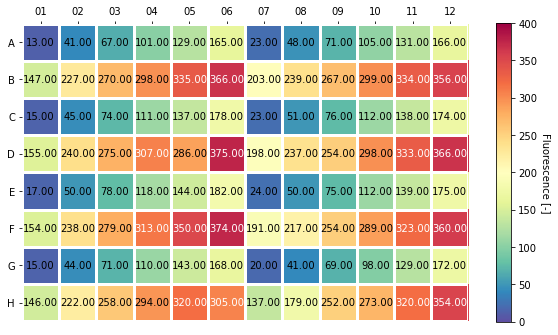

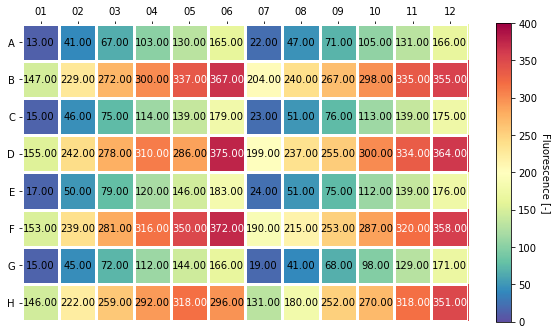

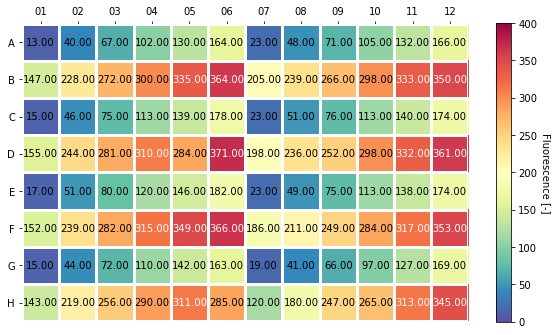

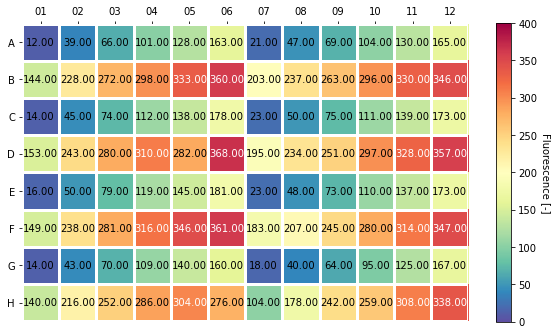

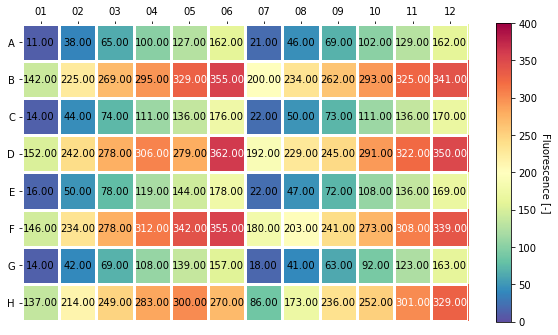

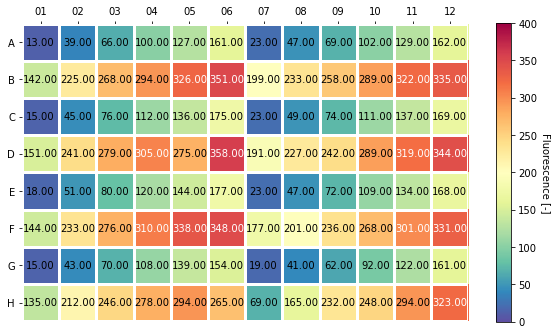

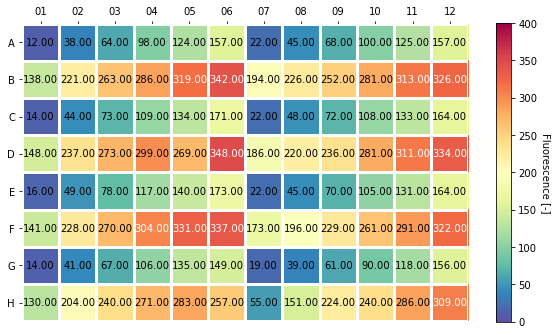

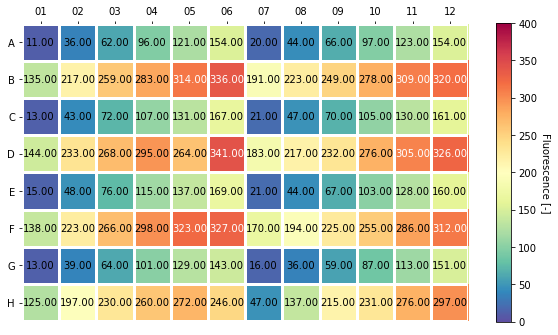

In [8]:
### Heatmap for all measurement points ###

row = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
column = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

mypath = fr'{dir_experiment}\{experiment_name}_Results_Heatmap-sGFP' 
if not os.path.isdir(mypath):
    os.makedirs(mypath)

for ai,x in enumerate(range(n)):
    fig, ax = plt.subplots(figsize = (10,10))
    array = numpy.array(merged_outputs.loc[x])
    array =array.reshape(8,12)
    
    im, cbar = helper.heatmap(array, row, column, ax = ax, cmap = 'Spectral_r',
                            cbar_kw = dict(shrink = 0.55), cbarlabel = 'Fluorescence [-]', vmin = 0, vmax = 400)
    texts = helper.annotate_heatmap(im, threshold = 300, valfmt = '{x:.2f}') #add annotations as two digit numbers

    plt.savefig(fr'{dir_experiment}\{experiment_name}_Results_Heatmap-sGFP\{experiment_name}_Heatmap_Time_{ai}.png'.format(ai=ai))


In [9]:
def getIndices(value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    position = pandas.read_excel(fr'{dir_experiment}/Wells.xlsx', sheet_name = 'MTP',index_col=0)
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = position.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((str(row)+str(col)))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos
#getIndices('YoaW')

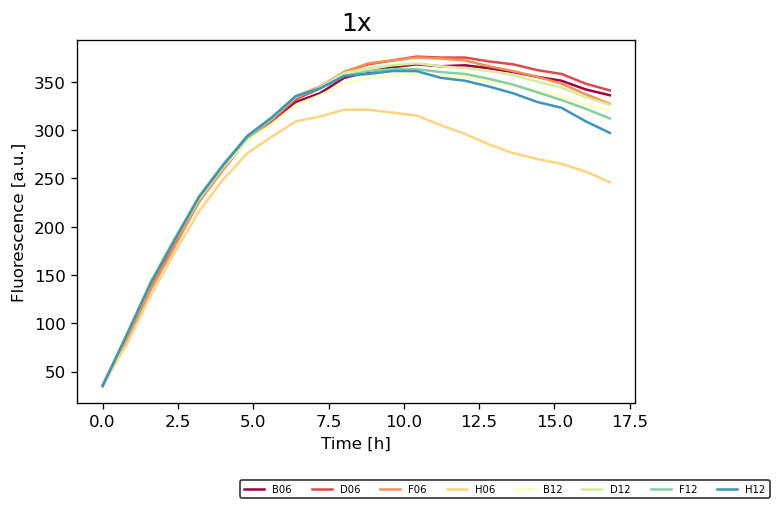

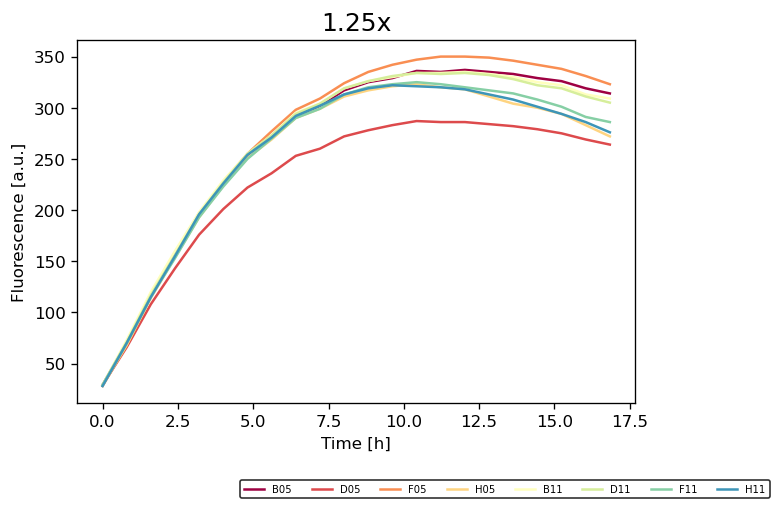

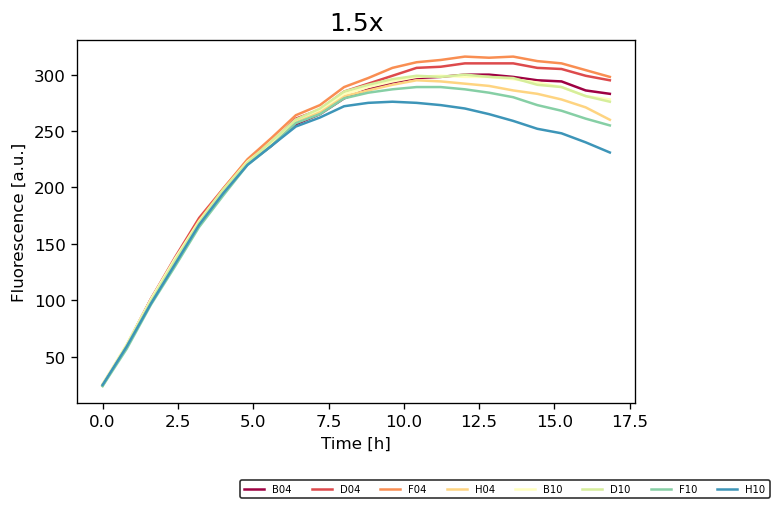

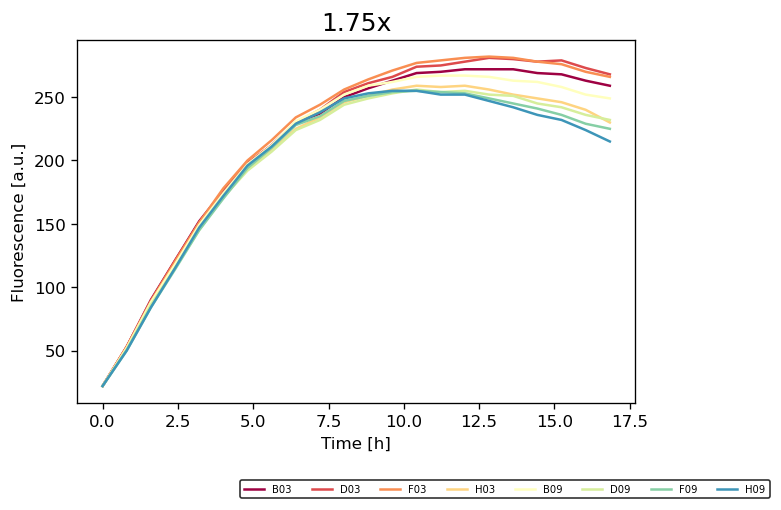

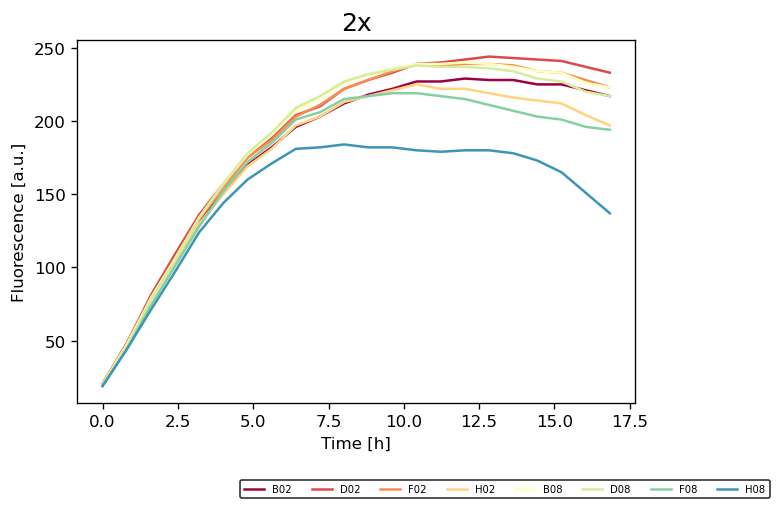

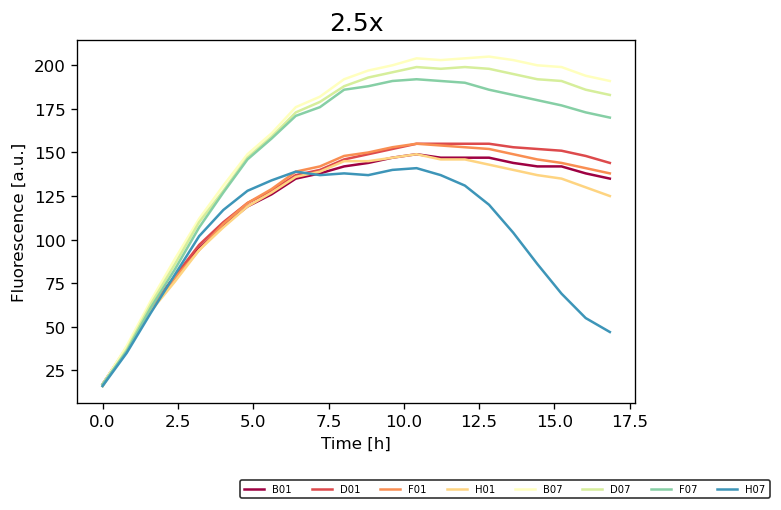

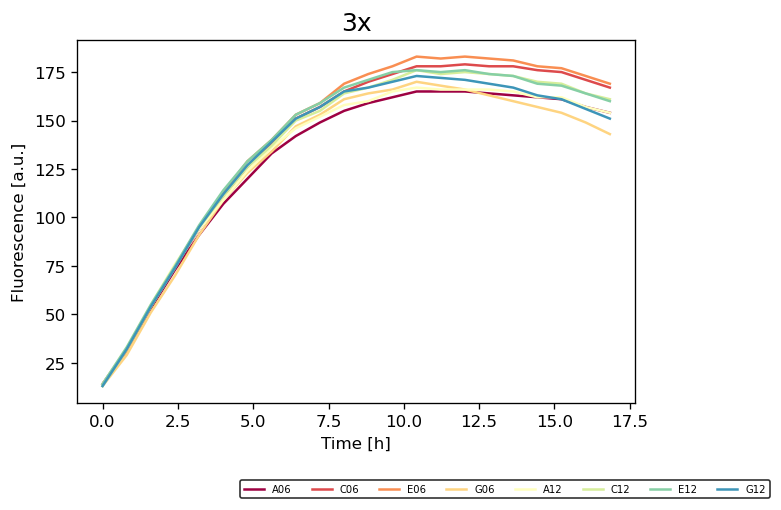

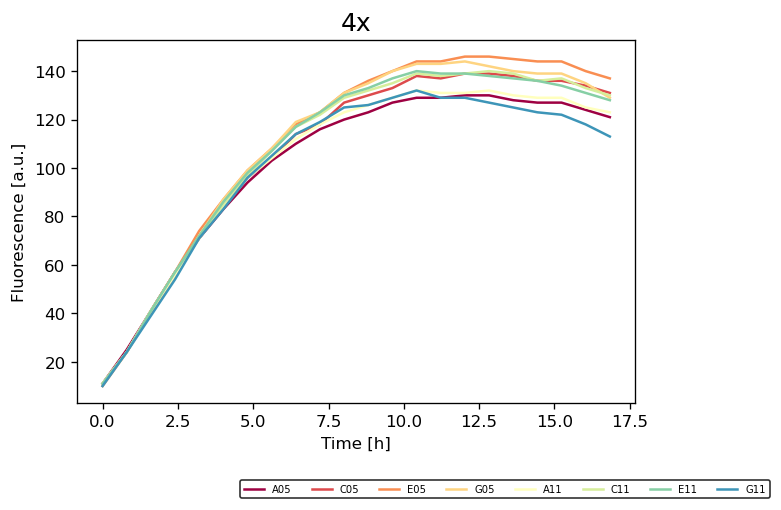

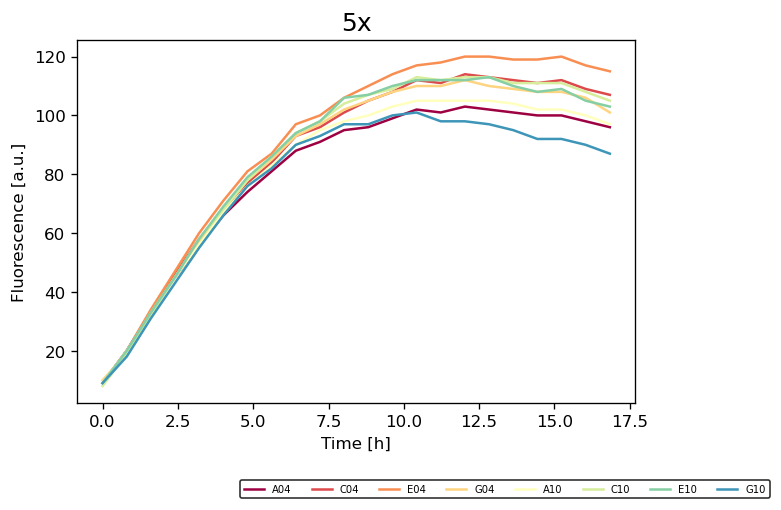

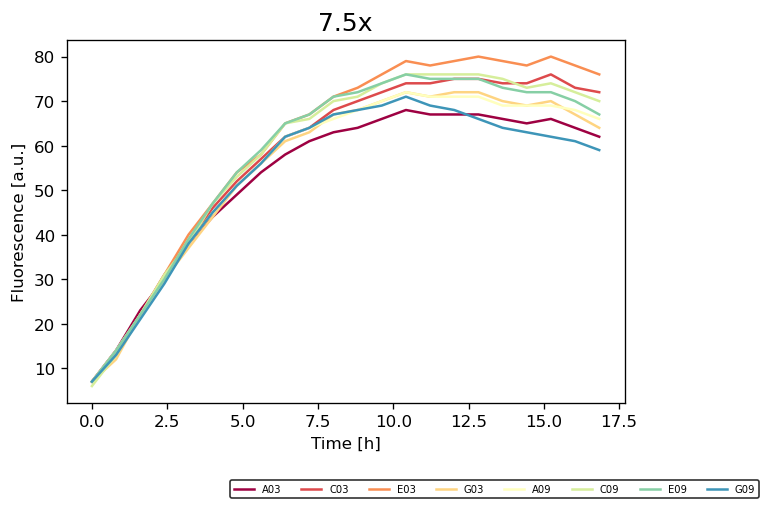

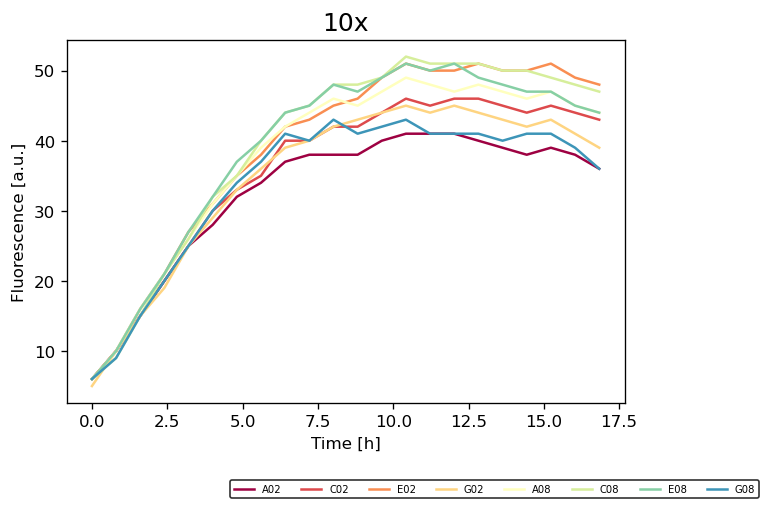

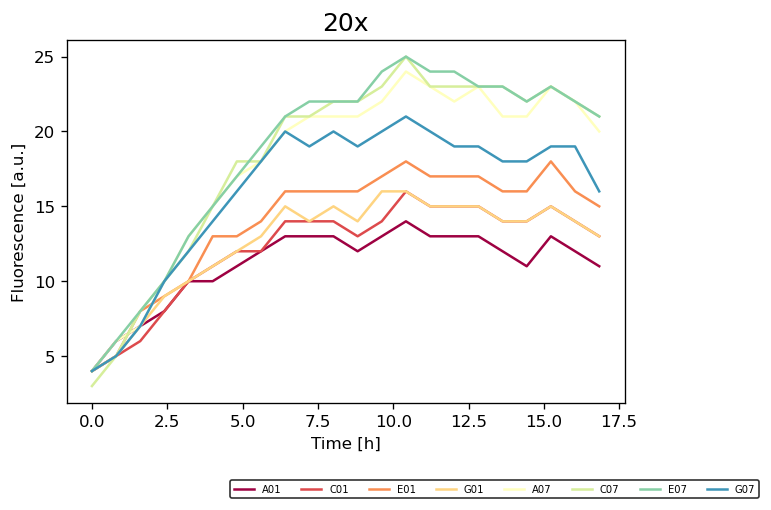

In [10]:
strain = ['1x', '1.25x', '1.5x', '1.75x', '2x', '2.5x', '3x', '4x', '5x', '7.5x', '10x', '20x']
data = merged_outputs

for i,s in enumerate(strain):
    wells = getIndices(s)
    mean = data[wells].mean(axis=1)
    std = data[wells].std(axis=1)

    fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=120, sharex=True)

    for w, well in enumerate(wells):
        color = plt.cm.Spectral(w/len(wells))

        ax.plot(time, merged_outputs[well], color = color, label = well)

        
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Fluorescence [a.u.]')
    ax.set_title('{}'.format(s), fontsize = 15)

    plt.legend(ncol = 12, edgecolor = 'black',  prop={'size':6}, bbox_to_anchor = (1.25,-0.2))
#     plt.savefig(fr'{dir_experiment}/{experiment_name}_Results/{experiment_name}_sGFPraw_{s[i]}', dpi= 300, bbox_inches='tight')

Text(0.5, 0, 'Time [h]')

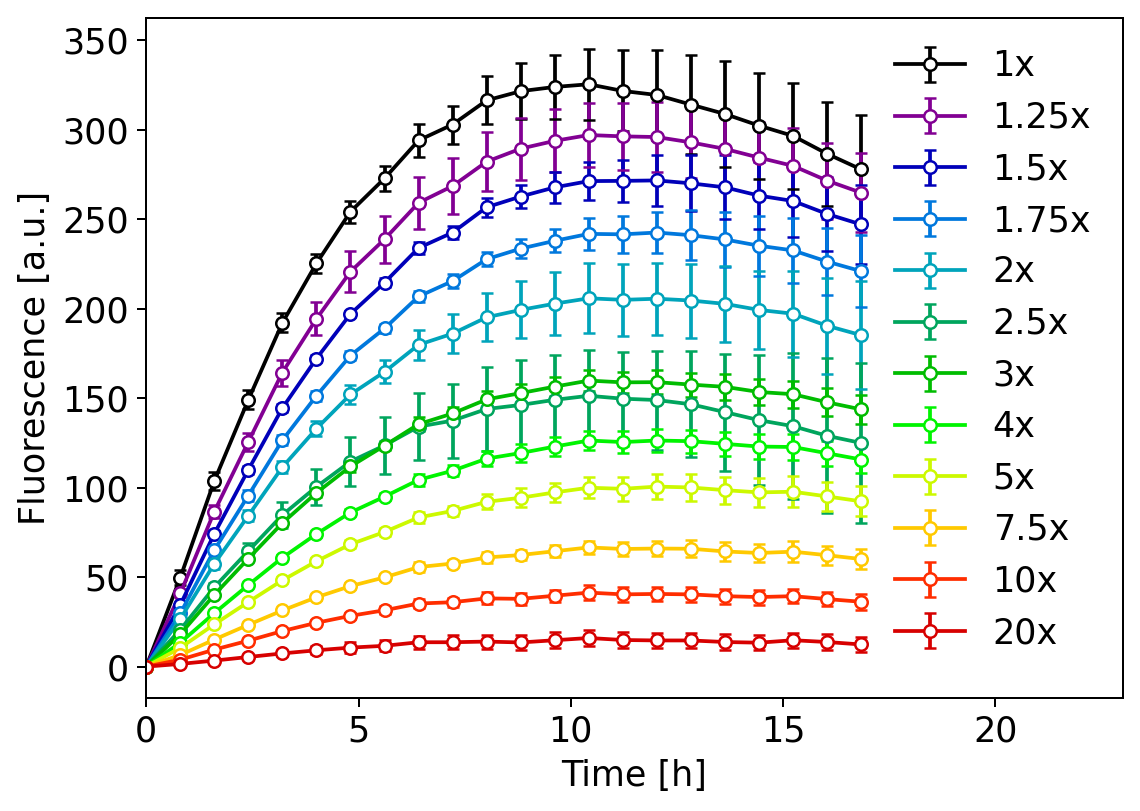

In [11]:
strain = ['1x', '1.25x', '1.5x', '1.75x', '2x', '2.5x', '3x', '4x', '5x', '7.5x', '10x', '20x']
#['D1, S1', 'D2, S1', 'D3, S1', 'D4, S1', 'D1, S2', 'D2, S2', 'D3, S2', 'D4, S2']
fontsize = 14

# labellist = ['Fresh detector solution', '7-month-old detector solution']
# colorlist = ['#023D6B', '#ADBDE3']
# markerlist = ['o', 's']

mean16h = []
std16h = []

#def plot_data(measurement,strain,induction):
meanplot = plt.figure(figsize=(7,5), dpi=180)

for i,s in enumerate(strain): 
    wells = getIndices(s)
    data[wells] = data[wells].apply(lambda x: x - numpy.min(x))
    
#     if s == '1x':
#         wells.remove('H06')
#     if s == '1.25x':
#         wells.remove('D05')
#     if s == '2x':
#         wells.remove('H08')
#     if s == '2.5x':
#         wells.remove('H07')

    
    mean = data[wells].mean(axis=1)
    std = data[wells].std(axis=1)

    mean16h.append(mean[14])
    std16h.append(std[14])
    
    color = plt.cm.nipy_spectral(i / len(strain))

    plt.errorbar(time, mean, yerr = std, fmt = 'o-', capsize = 2.5,  ms = 5, marker = 'o', mfc = 'white',  color = color, label = s)

plt.legend(loc = 'upper right', frameon = False, fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.xlim(0,23)
plt.ylabel('Fluorescence [a.u.]', fontsize = fontsize)
plt.xlabel('Time [h]', fontsize = fontsize)

In [12]:
meanplot.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_sGFP_S1', dpi=600, bbox_inches='tight')

# Data cutinase assay vs. sGFP

In [13]:
# safe fluorescence after 16 h and deviation in excel sheet

sGFP_16h = pandas.DataFrame({'Strain' : strain,
                             'Fluorescence [a.u.]' : mean16h,
                             'Standard deviation' : std16h }, 
                             columns=['Strain','Fluorescence [a.u.]', 'Standard deviation'])


sGFP_16h.to_excel(excel_writer = fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_result_sGFP.xlsx', sheet_name = 'sGFP')

sGFP_16h

,Strain,Fluorescence [a.u.],Standard deviation
0,1x,321.750,22.632152
1,1.25x,296.375,18.844761
2,1.5x,271.500,11.916375
3,1.75x,241.625,10.487237
4,2x,205.000,19.985709
5,2.5x,149.750,26.364207
6,3x,158.875,5.890367
7,4x,125.500,6.000000
8,5x,99.375,6.631903
9,7.5x,65.750,3.882194


In [14]:
ca = pandas.read_excel(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_result_cutinase.xlsx', sheet_name = 'cutinase',index_col=0)
sGFP = pandas.read_excel(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_result_sGFP.xlsx', sheet_name = 'sGFP',index_col=0)

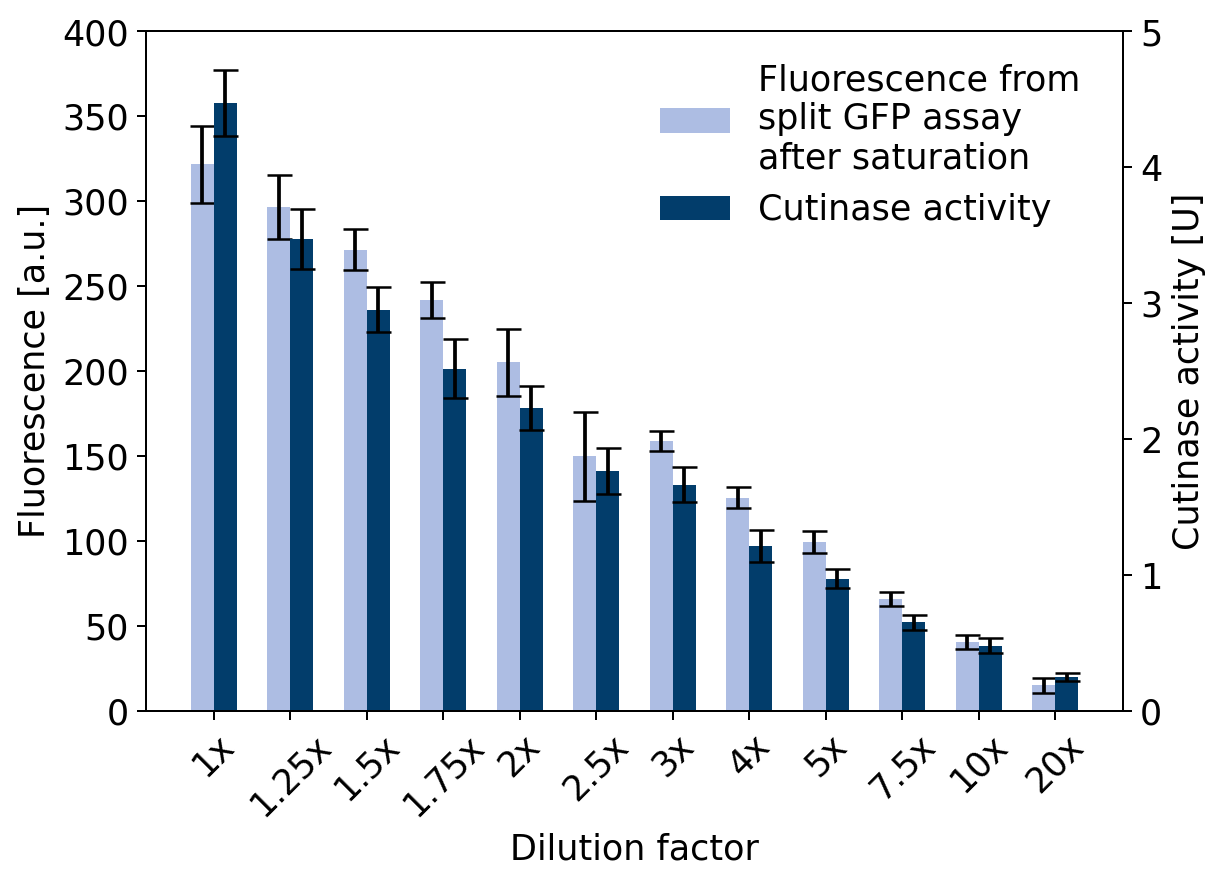

In [15]:
x = numpy.arange(len(strain))
w = 0.3
fontsize = 14
comparison = plt.figure(figsize=(7, 5), dpi=180)
ax1 = plt.subplot(1,1,1)

#plt.xticks(), will label the bars on x axis with the respective strain names.
plt.xticks(x + w /2, sGFP['Strain'], rotation=45, fontsize = fontsize)
Fluorescence = ax1.bar(x, sGFP['Fluorescence [a.u.]'], yerr = sGFP['Standard deviation'], capsize =5, width=w, color='#ADBDE3', align='center')
plt.ylabel('Fluorescence [a.u.]', fontsize = fontsize)
plt.xlabel('Dilution factor', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax1.set_ylim(0,400)

#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
Activity =ax2.bar(x + w, ca['Cutinase activity [U]'], yerr = ca['Standard deviation'], capsize =5, width=w,color='#023D6B',align='center')
plt.ylabel('Cutinase activity [U]', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax2.set_ylim(0,5)
plt.legend([Fluorescence, Activity],['Fluorescence from \nsplit GFP assay \nafter saturation', 'Cutinase activity'], loc = 'upper right', frameon = False, fontsize = fontsize)


In [16]:
comparison.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_Comparison_sGFP-cutinase', dpi=600, bbox_inches='tight')

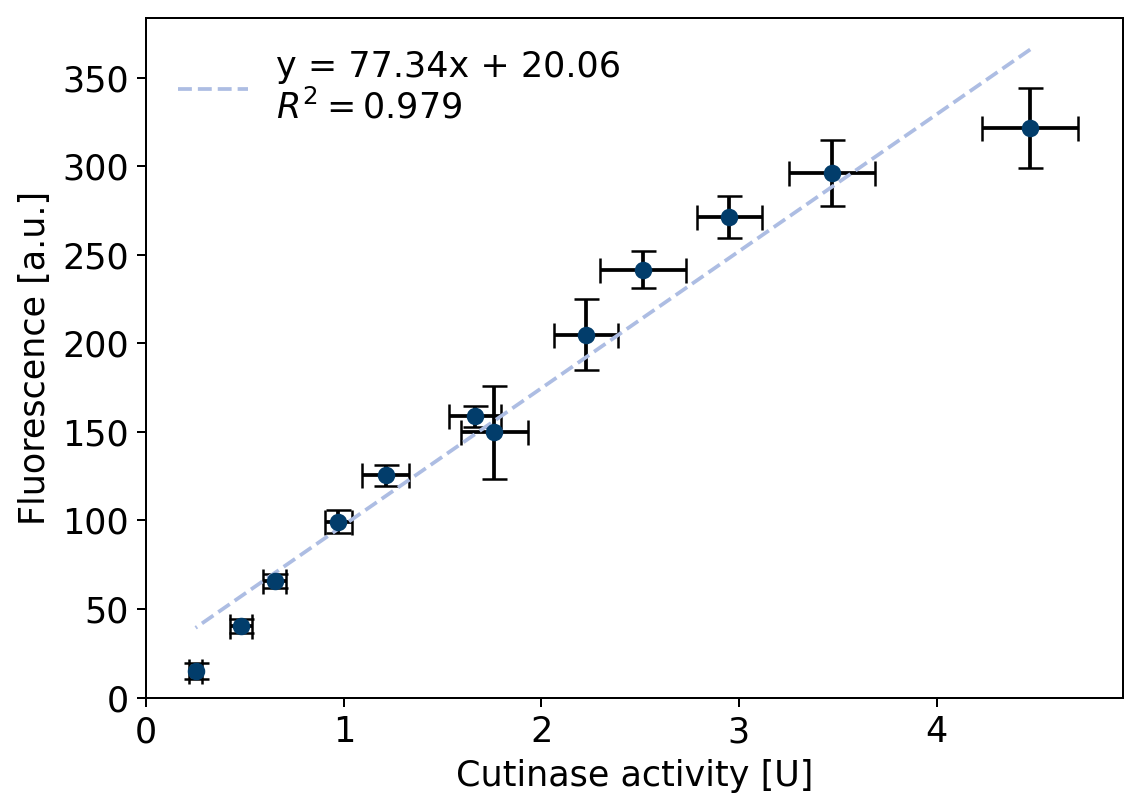

In [65]:
fontsize = 14

calib_slope, calib_intercept, calib_r_value, calib_p_value, calib_std_err = scipy.stats.linregress(
    ca['Cutinase activity [U]'], sGFP['Fluorescence [a.u.]'])
calib_r_value = round(calib_r_value,3)
calib_slope = round(calib_slope, 4)
calib_intercept = round(calib_intercept, 4)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,5), dpi = 180)

ax.errorbar(ca['Cutinase activity [U]'], sGFP['Fluorescence [a.u.]'],color = '#023D6B', yerr = sGFP['Standard deviation'], xerr = ca['Standard deviation'], capsize = 5,
            fmt = 'o', ecolor= 'k')
ax.plot(ca['Cutinase activity [U]'], calib_intercept + calib_slope*ca['Cutinase activity [U]'], 'r', 
        label=f'y = {round(calib_slope,2)}x + {round(calib_intercept,2)} \n$R^2 = {calib_r_value}$', color = '#ADBDE3', ls ='--')

ax.legend(frameon = False, fontsize = fontsize)

ax.set_ylim(0,)
ax.set_xlim(0,)

ax.set_xlabel('Cutinase activity [U]', fontsize = fontsize) #, fontweight = 'bold')
ax.set_ylabel('Fluorescence [a.u.]', fontsize = fontsize) #, fontweight = 'bold')

ax.tick_params(labelsize=fontsize)

# fig.tight_layout()

fig.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_Correlation_sGFP-cutinase', dpi=600, bbox_inches='tight')

Text(0, 0.5, 'Fluorescence [a.u.]')

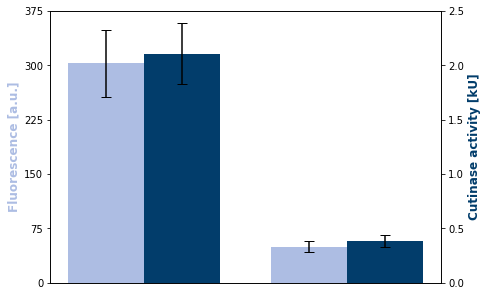

In [36]:
fontsize = 14

width = 0.35  # the width of the bars
#strain = ['NprE', 'Pel']
width = [0.2,1]
width1 = [0.5,1.3]

fig, ax = plt.subplots(1,1, figsize=(7,5))

spline = ax.twinx()

# links = ax.bar(ind, Pel_mean,  yerr = Pel_std, capsize =10, color = '#023D6B',width = 0.3)
# rechts = spline.bar(width1, NprE_mean , yerr = NprE_std, capsize =10, color = '#ADBDE3', width =0.3)

color_l= ['#023D6B', '#ADBDE3']
label =['NprE', 'Pel']

links = ax.bar(width, sGFP['Fluorescence [a.u.]'], yerr = sGFP['Standard deviation'], capsize =5, color ='#ADBDE3' ,
               width = 0.3, label = 'NprE')
rechts = spline.bar(width1, ca['Cutinase activity [U]'], yerr = ca['Standard deviation'], capsize =5, color = '#023D6B' , 
                    width =0.3, label = 'Pel')
spline.set_ylim(0, 2.5)

ax.tick_params(axis ='x', which = 'both', bottom =False, top =False, labelbottom = False)



ax.set_ylim(0,375)
ax.set_yticks(numpy.arange(0,380, 75.0))

# plt.xticks(names, rotation =45, size = 16)
# plt.yticks( size = 14)
# plt.ylim(bottom = 0, top = 1.8)
spline.set_ylabel('Cutinase activity [kU]', fontsize = 12, fontweight = 'bold', color = '#023D6B')
ax.set_ylabel('Fluorescence [a.u.]', fontsize = 12,  fontweight = 'bold', color ='#ADBDE3' )
# plt.legend()

# fig.savefig(fr'Comp_sGFP_CA', dpi=1200, bbox_inches='tight')

In [98]:
ca = pandas.read_excel('C06_cutinase_activity_singnal_peptide.xlsx') ## Excel-File that contains results of cutinase assay

In [100]:
### Measuremnet point of fluoerscence comparison ###
NprE_max = NprE_mean[19]
Pel_max = Pel_mean[19]

NprE_max_std = NprE_std[19]
Pel_max_std = Pel_std[19]


In [11]:
### Data preparation ###

sGFP_mean, sGFP_std = (NprE_max, Pel_max), (NprE_max_std, Pel_max_std)
ca_mean, ca_std = (ca.loc[1, 'mean'], ca.loc[0, 'mean']), (ca.loc[1, 'std'], ca.loc[0, 'std'])

Pel_mean, Pel_std = (Pel_max, ca.loc[0, 'mean']), (Pel_max_std, ca.loc[0, 'std'])
NprE_mean, NprE_std = (NprE_max, ca.loc[1, 'mean']), (NprE_max_std, ca.loc[1, 'std'])

In [101]:
### Plot ###
        
ind = numpy.arange(len(NprE_mean))  # the x locations for the groups
width = 0.35  # the width of the bars

names =['NprE', 'Pel']
width = [0.2,1]
width1 = [0.5,1.3]

names1 =['NprE1', 'Pel1']

fig, ax = plt.subplots(1,1, figsize=(7,5))

spline = ax.twinx()

color_l= ['#023D6B', '#ADBDE3']
label =['NprE', 'Pel']

links = ax.bar(width, sGFP_mean,  yerr = sGFP_std, capsize =5, color ='#ADBDE3' ,
               width = 0.28, label = 'Split GFP assay')
rechts = spline.bar(width1, ca_mean , yerr = ca_std, capsize =5, color = '#023D6B' , 
                    width =0.28, label = 'Cutinase activity assay')
spline.set_ylim(0,1.8)


spline.set_ylim(0,1.6)

ax.tick_params(axis ='x', which = 'both', bottom =False, top =False, labelbottom = False)



ax.set_ylim(0,375)
ax.set_yticks(numpy.arange(0,380, 75.0))


spline.set_ylabel('Cutinase activity [kU]', fontsize = 12, fontweight = 'bold')
ax.set_ylabel('Fluorescence [a.u.]', fontsize = 12,  fontweight = 'bold')
ax.legend(frameon =False, bbox_to_anchor = (0.9,0.94), fontsize = 10)
spline.legend(frameon =False, bbox_to_anchor = (1,1), fontsize = 10)

fig.savefig(fr'Präsi_Comp_sGFP_CA', dpi=1200, bbox_inches='tight')

NameError: name 'NprE_mean' is not defined

# Alternative data representation

In [13]:
row = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
column = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

array_sGFP = numpy.array(merged_outputs.loc[16])
array_sGFP = array_sGFP.reshape(8,12)

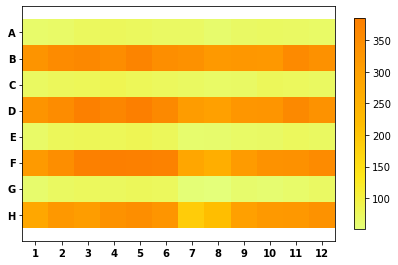

In [14]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
heatmap_sGFP = ax.imshow(array_sGFP, cmap = 'Wistia')
ax.set_xticks(numpy.arange(len(column)))
ax.set_yticks(numpy.arange(len(row)))

ax.set_xticklabels(column, fontsize = 10, fontweight = 'bold')
ax.set_yticklabels(row, fontsize = 10, fontweight = 'bold')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
fig.colorbar(heatmap_sGFP, shrink =0.775)

In [17]:
sample_plate = retl.parse('Output200313001_Sample.xml')
samples = sample_plate['Label1_Copy1'].value 

In [18]:
heat = numpy.array(samples.loc[30])
heat = heat.reshape(8,12)

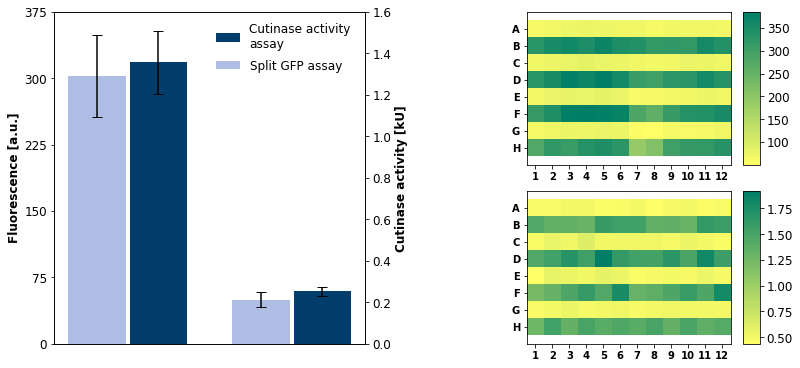

In [19]:
fig2 = plt.figure(constrained_layout = True, figsize = (11,5))
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[:, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 1])

heatmap_sGFP = f2_ax2.imshow(array_sGFP, cmap = 'summer_r')
f2_ax2.set_xticks(numpy.arange(len(column)))
f2_ax2.set_yticks(numpy.arange(len(row)))

f2_ax2.set_xticklabels(column, fontsize = 10, fontweight = 'bold')
f2_ax2.set_yticklabels(row, fontsize = 10, fontweight = 'bold')

bottom, top = f2_ax2.get_ylim()
f2_ax2.set_ylim(bottom + 0.5, top - 0.5)
cbar_up = fig2.colorbar(heatmap_sGFP, ax =f2_ax2,  shrink =1)
cbar_up.ax.tick_params(labelsize=12)
cbar_up.set_ticks(numpy.arange(0,500, 50.0)) 


heatmap_ca = f2_ax3.imshow(heat, cmap = 'summer_r')
f2_ax3.set_xticks(numpy.arange(len(column)))
f2_ax3.set_yticks(numpy.arange(len(row)))

f2_ax3.set_xticklabels(column, fontsize = 10, fontweight = 'bold')
f2_ax3.set_yticklabels(row, fontsize = 10, fontweight = 'bold')

bottom, top = f2_ax3.get_ylim()
f2_ax3.set_ylim(bottom + 0.5, top - 0.5)
cbar_down = fig2.colorbar(heatmap_ca,  shrink =1)
cbar_down.ax.tick_params(labelsize=12) 


sGFP_mean, sGFP_std = (NprE_max, Pel_max), (NprE_max_std, Pel_max_std)
ca_mean, ca_std = (ca.loc[1, 'mean'], ca.loc[0, 'mean']), (ca.loc[1, 'std'], ca.loc[0, 'std'])

width = [0.2,1]
width1 = [0.5,1.3]


spline = f2_ax1.twinx()

color_l= ['#023D6B', '#ADBDE3']
label =['NprE', 'Pel']

links = f2_ax1.bar(width, sGFP_mean,  yerr = sGFP_std, capsize =5, color ='#ADBDE3' ,
               width = 0.28, label = 'Split GFP assay')
rechts = spline.bar(width1, ca_mean , yerr = ca_std, capsize =5, color = '#023D6B' , 
                    width =0.28, label = 'Cutinase activity \nassay')
spline.set_ylim(0,1.8)


spline.set_ylim(0,1.6)

f2_ax1.tick_params(axis ='x', which = 'both', bottom =False, top =False, labelbottom = False)



f2_ax1.set_ylim(0,375)
f2_ax1.set_yticks(numpy.arange(0,380, 75.0))

spline.set_ylabel('Cutinase activity [kU]', fontsize = 12, fontweight = 'bold')
f2_ax1.set_ylabel('Fluorescence [a.u.]', fontsize = 12,  fontweight = 'bold')
f2_ax1.tick_params(labelsize = 12)
spline.tick_params(labelsize = 12)

f2_ax1.legend(frameon =False, bbox_to_anchor = (0.487,0.89), fontsize = 12)
spline.legend(frameon =False, bbox_to_anchor = (1,1), fontsize = 12)


# fig2.tight_layout()
# fig2.align_ylabels()

fig2.savefig('Comp_sGFP_ca_Heatmaps', dpi = 1200)

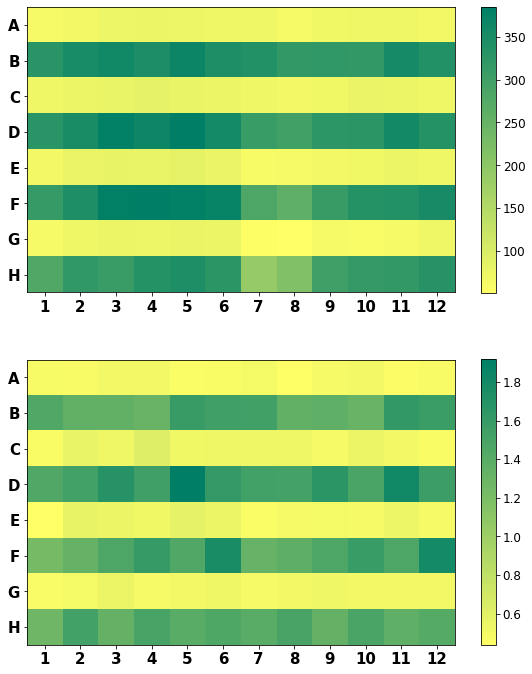

In [20]:
fig2, (f2_ax2, f2_ax3) = plt.subplots(nrows=2, ncols=1, figsize = (8,10))

heatmap_sGFP = f2_ax2.imshow(array_sGFP, cmap = 'summer_r')
f2_ax2.set_xticks(numpy.arange(len(column)))
f2_ax2.set_yticks(numpy.arange(len(row)))

f2_ax2.set_xticklabels(column, fontsize = 15, fontweight = 'bold')
f2_ax2.set_yticklabels(row, fontsize = 15, fontweight = 'bold')

bottom, top = f2_ax2.get_ylim()
# f2_ax2.set_ylim(bottom + 0.5, top - 0.5)
cbar_up = fig2.colorbar(heatmap_sGFP, ax =f2_ax2,  shrink =0.87)
cbar_up.ax.tick_params(labelsize=12)
cbar_up.set_ticks(numpy.arange(0,500, 50.0)) 


heatmap_ca = f2_ax3.imshow(heat, cmap = 'summer_r')
f2_ax3.set_xticks(numpy.arange(len(column)))
f2_ax3.set_yticks(numpy.arange(len(row)))

f2_ax3.set_xticklabels(column, fontsize = 15, fontweight = 'bold')
f2_ax3.set_yticklabels(row, fontsize = 15, fontweight = 'bold')

bottom, top = f2_ax3.get_ylim()
# f2_ax3.set_ylim(bottom + 0.5, top - 0.5)
cbar_down = fig2.colorbar(heatmap_ca,  shrink =0.87)
cbar_down.ax.tick_params(labelsize=12)

fig2.tight_layout()

fig2.savefig('Heatmap_C04_sGFP_ca', dpi = 1200)